### Installation

In [1]:
#!pip install git+https://www.github.com/huggingface/transformers
#!pip install git+https://github.com/huggingface/accelerate
#!pip install bitsandbytes
#!pip install einops
#!pip install --upgrade torch torchvision
#!pip install scikit-learn
#!pip install matplotlib
#!pip install datasets
#!pip install Bio
#!pip install pybedtools
#!pip install tabulate
#!pip install enformer-pytorch

## Paths & CKPT

In [2]:
### Datasets
# hg19 fasta file
FASTA_FILE = "/data/Dcode/gaetano/repos/Transformers4Genomic/data/hg19.fa"

# training files
bios_id = 'BioS73'
path_bios = '/data/Dcode/gaetano/repos/Transformers4Genomic/data/enhancers/biosamples/'

# dataset sample size
# 0.1 = 10%, 0.2 = 20%, .. , 1.00 = 100
sample_size = 1.0


### Model 
# model name from huggingface.co/model name_id:model_name
model_ckpt = 'InstaDeepAI/nucleotide-transformer-2.5b-1000g'

# Define configuration parameters
BATCH_SIZE = 32
LOG_STEPS = 500
LEARNING_RATE = 1e-5
NUM_EPOCHS = 20
TOKEN = 'TO ADD'
OUTPUT_DIR = f"{model_ckpt.split('/')[1]}_ft_Hepg2_1kbpHG19_DHSs_H3K27AC"

## Libraries

In [3]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel
from transformers.models.bert.configuration_bert import BertConfig
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
from Bio import SeqIO
from pybedtools import BedTool

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import random

2024-07-26 18:19:19.932276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 18:19:20.194646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 18:19:20.197459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 18:19:20.629157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 18:19:24.374312: W tensorflow/compiler/tf

## Model & Tokenizer

In [4]:
from transformers import AutoTokenizer, BigBirdForSequenceClassification, BertForSequenceClassification, BertConfig

# architecture configuration
def get_hf_model_tokenizer(model_ckpt=model_ckpt):
    
    #only for dnabert
    #config = BertConfig.from_pretrained(model_ckpt)

    # load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, trust_remote_code=True) 
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, trust_remote_code=True)
    #model = BigBirdForSequenceClassification.from_pretrained(model_ckpt, trust_remote_code=True, )
    return model, tokenizer

model, tokenizer = get_hf_model_tokenizer(model_ckpt=model_ckpt)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-2.5b-1000g and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
## for Gena models

#import importlib
#gena_module_name = model.__class__.__module__
#cls = getattr(importlib.import_module(gena_module_name), 'BertForSequenceClassification')
#model = cls.from_pretrained(model_ckpt, num_labels=2)
#print('\nclassification head:', model.classifier)

## Datasetes

### get fasta hg19 database

In [6]:
def get_chrom2seq(capitalize=True):

    chrom2seq = {}
    for seq in SeqIO.parse(FASTA_FILE, "fasta"):
        chrom2seq[seq.description.split()[0]] = seq.seq.upper() if capitalize else seq.seq

    return chrom2seq

chrom2seq = get_chrom2seq()

### Get HepG2 data - sequences

In [7]:
def get_bios_sequences(bios_id=bios_id, path_bios=path_bios, chrom2seq=chrom2seq):
    pos_beds = list(BedTool(f'{path_bios}{bios_id}_positive_1kb.bed'))
    ctrl_beds = list(BedTool(f'{path_bios}{bios_id}_control_1kb.bed'))

    pos_list = []
    ctrl_list = []
    for chr, start, end  in pos_beds:
        pos_list.append(str(chrom2seq[chr][int(start):int(end)]))

    for chr, start, end  in ctrl_beds:
        ctrl_list.append(str(chrom2seq[chr][int(start):int(end)]))

    ctrl_list = random.sample(ctrl_list, len(pos_list))
    seq_data = []
    seq_data.extend(pos_list)
    seq_data.extend(ctrl_list)

    labels_data = []
    labels_data.extend([1 for _ in range(len(pos_list))])
    labels_data.extend([0 for _ in range(len(ctrl_list))])

    return seq_data, labels_data

seq_data, labels_data = get_bios_sequences(bios_id=bios_id, path_bios=path_bios, chrom2seq=chrom2seq)

### Create dataframe and remove Ns seq

In [8]:

def get_clean_sample(seq_data, labels_data, sample_size=sample_size):
    # Create DataFrame
    bioS = pd.DataFrame({'seq_data': seq_data, 'labels': labels_data})

    # Filter out rows with sequences consisting only of the same character (presumably Ns)
    bioS_no_Ns = bioS[bioS['seq_data'].apply(lambda x: len(set(x)) > 1)]

    # take a sample based on sample_size
    bioS_no_Ns_sampled = bioS_no_Ns.sample(round(len(bioS_no_Ns)*sample_size),random_state=10)
    bioS_no_Ns_sampled['labels'].value_counts()
    return bioS_no_Ns_sampled

bioS_no_Ns_sampled = get_clean_sample(seq_data=seq_data, labels_data=labels_data, sample_size=sample_size)

### Split train/val/test

In [9]:
def datasets_split_train_val_test(bioS_no_Ns_sampled=bioS_no_Ns_sampled):
    # Get training data
    train_sequences_bioS = bioS_no_Ns_sampled['seq_data'].tolist()
    train_labels_bioS = bioS_no_Ns_sampled['labels'].tolist()

    # Split the dataset into a training and a validation dataset
    train_sequences_bioS, test_sequences_bioS, train_labels_bioS, test_labels_bioS = train_test_split(train_sequences_bioS,
                                                                                  train_labels_bioS, test_size=0.20, random_state=42)

    # Split the test data into validation and test sets
    validation_sequences_bioS, test_sequences_bioS, validation_labels_bioS, test_labels_bioS = train_test_split(test_sequences_bioS, test_labels_bioS, test_size=0.50, random_state=42)

    # Create datasets from dictionaries
    ds_train_bioS = Dataset.from_dict({"data": train_sequences_bioS, "labels": train_labels_bioS})
    ds_validation_bioS = Dataset.from_dict({"data": validation_sequences_bioS, "labels": validation_labels_bioS})
    ds_test_bioS = Dataset.from_dict({"data": test_sequences_bioS, "labels": test_labels_bioS})
    
    return ds_train_bioS, ds_validation_bioS, ds_test_bioS

ds_train_bioS, ds_validation_bioS, ds_test_bioS = datasets_split_train_val_test(bioS_no_Ns_sampled=bioS_no_Ns_sampled)

### Tokenize the dataset

In [10]:
def get_tokenized_dataset(tokenizer, max_length=512):

    def tokenize_function(examples):
        # Encode sequences
        encoding = tokenizer(
            examples['data'],
            truncation=True,
            max_length=max_length,
            padding=True,
            return_tensors="pt"
        )
        
        # Add labels to the encoding
        encoding['labels'] = examples['labels']
        
        return encoding
    
    # Tokenize and process the datasets
    tokenized_train = ds_train_bioS.map(tokenize_function, batched=True, remove_columns=["data"])
    tokenized_validation = ds_validation_bioS.map(tokenize_function, batched=True, remove_columns=["data"])
    tokenized_test = ds_test_bioS.map(tokenize_function, batched=True, remove_columns=["data"])

    return tokenized_train, tokenized_validation, tokenized_test

ds_tokenized_train, ds_tokenized_validation, ds_tokenized_test = get_tokenized_dataset(tokenizer, max_length=512)

Map:   0%|          | 0/21449 [00:00<?, ? examples/s]

Map:   0%|          | 0/2681 [00:00<?, ? examples/s]

Map:   0%|          | 0/2682 [00:00<?, ? examples/s]

## Training 

### Training Args

In [11]:
from transformers import EarlyStoppingCallback, IntervalStrategy
from transformers import TrainingArguments, Trainer, get_scheduler


def get_train_args(OUTPUT_DIR, BATCH_SIZE, LEARNING_RATE, LOG_STEPS, TOKEN):
    return TrainingArguments(
        output_dir=OUTPUT_DIR,  # Directory to save model and logs
        per_device_train_batch_size=8,  # Training batch size per device
        per_device_eval_batch_size=8,  # Evaluation batch size per device
        learning_rate=1e-5,  # Learning rate
        num_train_epochs=NUM_EPOCHS,  # Number of training epochs
        logging_steps=LOG_STEPS,  # Logging interval
        weight_decay=0.01,
        gradient_accumulation_steps=1, 
        #warmup_steps=50,
        #gradient_accumulation_steps = 32,
        #gradient_checkpointing = True,
        logging_dir='./logs',  # Directory to store logs
        eval_strategy="steps",  # Evaluation strategy
        save_strategy="steps",  # Save strategy
        save_total_limit=5,  # Maximum number of saved models
        disable_tqdm=False,  # Enable tqdm progress bars
        load_best_model_at_end=True,  # Load best model at the end of training
        metric_for_best_model="f1_score",  # Metric to select the best model
        label_names=["labels"],
        optim="adamw_torch",
        fp16=True,  # Enable mixed precision training
        push_to_hub=True,  # Push model to Hugging Face hub
        hub_token=TOKEN  # Authentication token for Hugging Face hub   

    )


batch_size = 8
model_name='nucleotide-transformer'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= batch_size,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 3000
)
     
# Define the EarlyStoppingCallback with patience
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=20,                # number of evaluations with no improvement
    early_stopping_threshold=0.001             # threshold for measuring improvement
)

training_args = get_train_args(OUTPUT_DIR, BATCH_SIZE, LEARNING_RATE, LOG_STEPS, TOKEN)


/vf/users/Dcode/gaetano/venv/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Metrics

In [12]:
from sklearn import metrics


def compute_metrics_f1_score(eval_pred):
    """Computes F1 score for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r={'f1_score': metrics.f1_score(references, predictions)}
    return r

## Metric Regression
def compute_metrics_regression(eval_pred):
    predictions, labels = eval_pred

    mse = metrics.mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(labels, predictions)
    r_squared = metrics.r2_score(labels, predictions)
    
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r_squared": r_squared
    }



# Define the metric for the evaluation using the f1 score
def compute_metrics_classification_binary(eval_pred):
    """Computes F1 score for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    
    r={'f1_score': metrics.f1_score(references, predictions),
       'precision': metrics.precision_score(references, predictions),
       'recall': metrics.recall_score(references, predictions),
       'accuracy': metrics.accuracy_score(references, predictions),
       #'mcc_score': metrics.matthews_corrcoef(references, predictions),
       #'roc_auc_score': metrics.roc_auc_score(references, predictions),
       }
    
    return r

def compute_metrics_basic(eval_pred):
    predictions, references = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': (predictions==references).sum() / len(references),'f1_score': metrics.f1_score(references, predictions) }

### Train

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_data), y=labels_data)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights = class_weights.to(device)

# Define a custom Trainer class to use weighted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss



In [14]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized_train,
    eval_dataset=ds_tokenized_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_classification_binary,
    callbacks=[early_stopping_callback]       # add early stopping callback
)
# Train the model
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,F1 Score,Precision,Recall,Accuracy
500,0.450000,0.411824,0.843357,0.842767,0.843947,0.832898
1000,0.386200,0.363913,0.862069,0.849762,0.874738,0.850802
1500,0.397500,0.390377,0.869001,0.809668,0.937719,0.849310
2000,0.368100,0.358993,0.873826,0.839458,0.911127,0.859754
2500,0.356700,0.401472,0.873276,0.806280,0.952414,0.852667
3000,0.280800,0.674395,0.825067,0.915529,0.750875,0.830287
3500,0.216400,0.577034,0.874672,0.823348,0.932820,0.857516
4000,0.210400,0.594072,0.881706,0.841603,0.925822,0.867587
4500,0.211500,0.554570,0.875469,0.854194,0.897831,0.863857
5000,0.207500,0.543107,0.870116,0.875354,0.864941,0.862365


TrainOutput(global_step=21000, training_loss=0.09729646899586632, metrics={'train_runtime': 12256.8063, 'train_samples_per_second': 34.999, 'train_steps_per_second': 4.376, 'total_flos': 7.300594941546625e+17, 'train_loss': 0.09729646899586632, 'epoch': 7.829977628635347})

In [15]:
  trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/236M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tanoManzo/nucleotide-transformer-2.5b-1000g_ft_Hepg2_1kbpHG19_DHSs_H3K27AC/commit/97e8820fec693a7dd9133bebc3c262e5b8ec8c7c', commit_message='End of training', commit_description='', oid='97e8820fec693a7dd9133bebc3c262e5b8ec8c7c', pr_url=None, pr_revision=None, pr_num=None)

# Evaluation

In [16]:
from tabulate import tabulate

# Evaluate the model
eval_results = trainer.predict(ds_tokenized_test)


# Print evaluation results in a table format
print(tabulate(eval_results.metrics.items(), headers=["Metric", "Value"]))

Metric                        Value
-----------------------  ----------
test_loss                  1.48884
test_f1_score              0.867577
test_precision             0.80443
test_recall                0.941481
test_accuracy              0.855332
test_runtime              24.2312
test_samples_per_second  110.684
test_steps_per_second     13.866


In [17]:
ds_tokenized_test['labels']

[1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,


## Get data

In [18]:
# Assuming predictions are probabilities for the positive class
# and true_labels are binary (0 or 1)
predictions_positive_class = eval_results.predictions[:, 1]
true_labels = eval_results.label_ids

## Get ROC

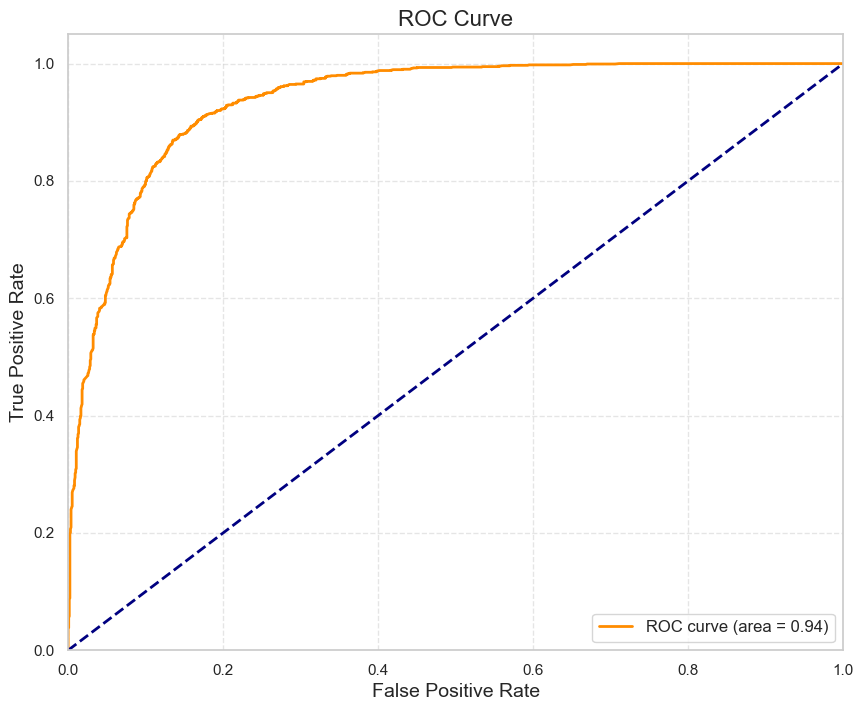

In [19]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(true_labels, predictions_positive_class)
roc_auc = auc(fpr, tpr)

# Set up Seaborn style
sns.set(style='whitegrid')

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend(loc='lower right', fontsize=12)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
 
# Show the plot
plt.show()

## Get PRC

In [1]:
from sklearn.metrics import precision_recall_curve, auc
# Create a new figure
plt.figure(figsize=(10, 8))

# Compute precision-recall curve and area under the curve (AUC)
precision, recall, thresholds = precision_recall_curve(true_labels, predictions_positive_class)
prc_auc = auc(recall, precision)

# Set up Seaborn style
sns.set(style='whitegrid')


# Plot Precision-Recall curve
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PRC curve (area = {prc_auc:.2f})')

# Add labels and title
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title(f"Precision-Recall Curve {model_ckpt.split('/')[1]}", fontsize=16)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend(loc='lower left', fontsize=12)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


# Show the plot
plt.show()

NameError: name 'plt' is not defined

## Save Results

In [21]:
import os
save_dir = f"/data/Dcode/gaetano/models_comparisons/{model_ckpt.split('/')[-1]}/{bios_id}"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save area under the curve (AUC)
with open(os.path.join(save_dir, "auc.txt"), "w") as of:
    of.write("AUC: %f\n" % roc_auc)

# Save ROC values
with open(os.path.join(save_dir, "roc_values.txt"), "w") as of:
        of.write("FPR\tTPR\tTHR\n")
        for fpr, tpr, thr in zip(fpr, tpr, thresholds):
            of.write("%f\t%f\t%f\n" % (fpr, tpr, thr))

# Save area under the PRC
with open(os.path.join(save_dir, "prc.txt"), "w") as of:
    of.write("PRC: %f\n" % prc_auc)

## raQTL

get raqtl data

In [22]:
# raQTL
dataset_path = "/data/Dcode/gaetano/repos/Transformers4Genomic/data/raQTL/hepg2.sign.id.LP190708.txt"
lenght_bp = 999 #plus ref/alt 1kb total

# data path
raqtl_df = pd.read_csv(dataset_path, sep='\t')

# reference and alternative sequences (number of bp based on lenght_bp)
seq_ref = []
seq_alt = []
for _, row in raqtl_df.iterrows():
    chromosome = row['chr']
    abspos = row['SNPabspos']
    seq = str(chrom2seq[chromosome][(abspos - 1 - int(lenght_bp / 2)):abspos + int(lenght_bp / 2)])
    seq_ref.append(seq)
    seq_alt.append(f"{seq[:int(len(seq)/2)]}{row['alt']}{seq[int(len(seq)/2)+1:]}")

ds_raqtl_ref = Dataset.from_dict({"data": seq_ref, "labels": [idx%2 for idx in range(len(seq_ref))]})
ds_raqtl_alt = Dataset.from_dict({"data": seq_alt, "labels": [idx%2 for idx in range(len(seq_ref))]})

tokenize data

In [23]:
def get_tokenized_eval(tokenizer, max_length=512):

    def tokenize_function(examples):
        # Encode sequences
        encoding = tokenizer(
            examples['data'],
            truncation=True,
            max_length=max_length,
            padding=True,
            return_tensors="pt"
        )
        
        # Add labels to the encoding
        encoding['labels'] = examples['labels']
        
        return encoding
    
    # Tokenize and process the datasets
    tokenized_ref = ds_raqtl_ref.map(tokenize_function, batched=True, remove_columns=["data"])
    tokenized_alt = ds_raqtl_alt.map(tokenize_function, batched=True, remove_columns=["data"])
 
    return tokenized_ref, tokenized_alt

tokenized_ref, tokenized_alt = get_tokenized_eval(tokenizer, max_length=512)

Map:   0%|          | 0/14183 [00:00<?, ? examples/s]

Map:   0%|          | 0/14183 [00:00<?, ? examples/s]

Get predictions

In [24]:
# Evaluate the model
eval_results_ref = trainer.predict(tokenized_ref)
eval_results_alt = trainer.predict(tokenized_alt)


save predictions

In [25]:
import pickle

# Assuming predictions_ref and predictions_alt are defined
predictions_ref = eval_results_ref.predictions
predictions_alt = eval_results_alt.predictions

# Save to a file
with open(f'/data/Dcode/gaetano/repos/Transformers4Genomic/data/raQTL/{OUTPUT_DIR}_predictions.pkl', 'wb') as f:
    pickle.dump({'predictions_ref': predictions_ref, 'predictions_alt': predictions_alt}, f)

In [26]:
predictions_ref

array([[-2.6855469,  2.5527344],
       [ 8.4609375, -6.9765625],
       [-3.8554688,  3.5761719],
       ...,
       [ 5.7304688, -4.6445312],
       [ 5.2890625, -4.3164062],
       [-6.6523438,  6.0429688]], dtype=float32)

# Extra

In [27]:
#import torch
#from transformers import AdamW, get_scheduler
#
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#model.to(device)
#
#optimizer = AdamW(model.parameters(), lr=5e-5)
#
#num_epochs = 3
#num_training_steps = num_epochs * len(ds_tokenized_train)
#
#lr_scheduler = get_scheduler(
#    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
#)
#
#from tqdm.auto import tqdm
#
#progress_bar = tqdm(range(num_training_steps))
#
#model.train()
#for epoch in range(num_epochs):
#    for batch in ds_tokenized_train:
#        #batch = {k: v.to(device) for k, v in batch.items()}
#        outputs = model(**batch)
#        loss = outputs.loss
#        loss.backward()
#
#        optimizer.step()
#        lr_scheduler.step()
#        optimizer.zero_grad()
#        progress_bar.update(1)
#
#with torch.no_grad():
#  output = model(**tokenizer("ATATATA",truncation=True, max_length=512, padding=True, return_tensors="pt").to(device))
#  
#print(output['logits'])

In [28]:
torch.cuda.empty_cache()
